### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import ast
import pickle
import os
import warnings
import random
from datetime import datetime

# Machine Learning & NLP
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# UI Interface
import gradio as gr

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings("ignore")

print("Semua library berhasil diimport!")

C:\Users\ryana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Semua library berhasil diimport!


### LOAD DATASET

In [2]:
def load_dataset(filepath="dataset/movies_metadata.csv"):
    """
    Load dataset film dari file CSV
    """
    print("Loading dataset...")

    try:
        df = pd.read_csv(filepath, low_memory=False)
        print(f"Dataset loaded: {df.shape[0]} baris, {df.shape[1]} kolom")

        # Tampilkan informasi dataset
        print("\nInformasi Dataset:")
        print(f"Kolom tersedia: {df.columns.tolist()}")
        print(f"Tipe data:\n{df.dtypes}")

        return df

    except FileNotFoundError:
        print(f"Error: File {filepath} tidak ditemukan!")
        print("Pastikan file dataset berada di folder 'dataset/'")
        return None

# Load dataset
df = load_dataset()

if df is not None:
    print("\nSample data (5 baris pertama):")
    display(df.head())

Loading dataset...
Dataset loaded: 45466 baris, 24 kolom

Informasi Dataset:
Kolom tersedia: ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']
Tipe data:
adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  floa

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


### PREPROCESSING

In [3]:
def preprocess_data(df):
    """
    Preprocessing data film
    """
    print("Memulai preprocessing data...")

    # Pilih kolom yang relevan
    relevant_cols = ['title', 'overview', 'genres', 'original_language',
                     'vote_average', 'vote_count', 'release_date', 'runtime',
                     'tagline', 'status']

    # Filter kolom yang ada
    existing_cols = [col for col in relevant_cols if col in df.columns]
    df = df[existing_cols]

    # Hapus baris dengan data penting yang kosong
    initial_rows = len(df)
    df = df.dropna(subset=['title', 'overview'])
    print(f"Dihapus {initial_rows - len(df)} baris dengan title/overview kosong")

    # Reset index
    df.reset_index(drop=True, inplace=True)

    # Fungsi untuk membersihkan judul
    def clean_title(title):
        if pd.isna(title):
            return ''
        title = str(title)
        title = re.sub(r'[^a-zA-Z0-9\s\-\:\&\']', ' ', title)
        title = title.lower().strip()
        title = re.sub(r'\s+', ' ', title)
        return title

    # Fungsi untuk ekstrak genre
    def extract_genres(genre_str):
        if pd.isna(genre_str):
            return ''
        try:
            if isinstance(genre_str, str):
                try:
                    genres_list = ast.literal_eval(genre_str)
                    if isinstance(genres_list, list):
                        genre_names = []
                        for genre in genres_list:
                            if isinstance(genre, dict) and 'name' in genre:
                                genre_names.append(genre['name'].lower())
                        return ', '.join(genre_names)
                except:
                    # Fallback: ekstrak manual
                    matches = re.findall(r"'name':\s*'([^']+)'", str(genre_str))
                    if matches:
                        return ', '.join([m.lower() for m in matches])
        except Exception as e:
            print(f"Error parsing genres: {e}")
        return ''

    # Fungsi untuk parse tahun
    def parse_year(date_str):
        if pd.isna(date_str):
            return 0
        try:
            if isinstance(date_str, str):
                if '-' in date_str:
                    parts = date_str.split('-')
                    if len(parts) > 0 and parts[0].isdigit():
                        return int(parts[0])
                # Cari 4 digit angka
                matches = re.findall(r'\d{4}', str(date_str))
                if matches:
                    return int(matches[0])
        except:
            pass
        return 0

    # Terapkan fungsi cleaning
    df['title_clean'] = df['title'].apply(clean_title)
    df['genres_clean'] = df['genres'].apply(extract_genres)
    df['year'] = df['release_date'].apply(parse_year)

    # Handle missing values
    df['tagline'] = df['tagline'].fillna('')
    df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce').fillna(0)
    df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce').fillna(0)
    df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce').fillna(0)

    # Filter film dengan minimal votes
    df = df[df['vote_count'] > 10]

    # Gabungkan teks untuk embedding
    df['combined_text'] = df['overview'] + ' ' + df['genres_clean']
    df['search_text'] = df['title_clean'] + ' ' + df['genres_clean']

    print(f"\nPreprocessing selesai!")
    print(f"Total film setelah preprocessing: {len(df)}")

    # Tampilkan statistik
    print(f"\nStatistik Dataset:")
    print(f"Rata-rata rating: {df['vote_average'].mean():.2f}")
    print(f"Rentang tahun: {df['year'].min()} - {df['year'].max()}")
    print(f"Film dengan rating tertinggi: {df.loc[df['vote_average'].idxmax(), 'title']} ({df['vote_average'].max():.1f})")

    return df

# Preprocess data
if df is not None:
    df = preprocess_data(df)
    print("\nSample data setelah preprocessing:")
    display(df[['title', 'genres_clean', 'year', 'vote_average']].head())

Memulai preprocessing data...
Dihapus 960 baris dengan title/overview kosong

Preprocessing selesai!
Total film setelah preprocessing: 21604

Statistik Dataset:
Rata-rata rating: 6.19
Rentang tahun: 0 - 2020
Film dengan rating tertinggi: Planet Earth II (9.5)

Sample data setelah preprocessing:


,title,genres_clean,year,vote_average
0,Toy Story,"animation, comedy, family",1995,7.7
1,Jumanji,"adventure, fantasy, family",1995,6.9
2,Grumpier Old Men,"romance, comedy",1995,6.5
3,Waiting to Exhale,"comedy, drama, romance",1995,6.1
4,Father of the Bride Part II,comedy,1995,5.7


### ARSITEKTUR TRANSFORMER & EMBEDDING


Membuat embeddings baru...
Loading model Sentence Transformer...

Model Transformer yang digunakan:
Nama: all-MiniLM-L6-v2
Tipe: Transformer-based Neural Network
Arsitektur: MiniLM (distilled BERT)
Layers: 6 Transformer encoder layers
Hidden size: 384
Parameters: ~80 juta
Training: Knowledge distillation dari model yang lebih besar

Membuat embeddings untuk sinopsis film...


Batches: 100%|██████████| 676/676 [04:21<00:00,  2.58it/s]



Membuat model Nearest Neighbors...

Embeddings berhasil dibuat: (21604, 384)
Model disimpan di: movie_embeddings.pkl, movie_nn_model.pkl

Visualisasi distribusi embedding...


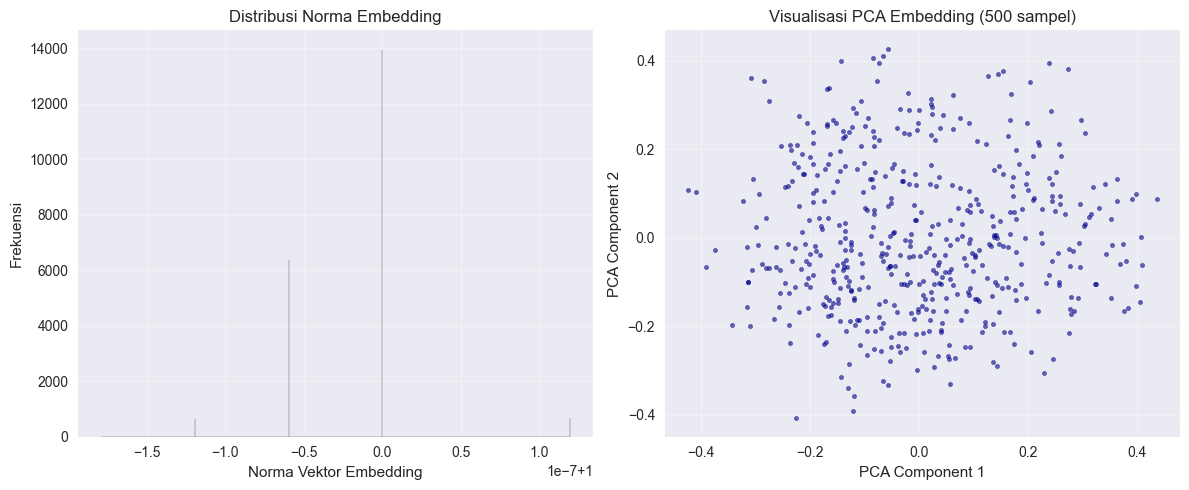

In [13]:
def create_embeddings(df, force_recreate=False):
    """
    Buat embedding menggunakan model Transformer
    """
    embedding_file = 'movie_embeddings.pkl'
    model_file = 'movie_nn_model.pkl'

    if not force_recreate and os.path.exists(embedding_file) and os.path.exists(model_file):
        print("Loading embeddings dan model yang sudah tersimpan...")

        with open(embedding_file, 'rb') as f:
            movie_embeddings = pickle.load(f)

        with open(model_file, 'rb') as f:
            nn_model = pickle.load(f)

        print(f"Embeddings loaded: {movie_embeddings.shape}")

    else:
        print("Membuat embeddings baru...")

        # Load model Transformer
        print("Loading model Sentence Transformer...")
        model = SentenceTransformer('all-MiniLM-L6-v2')

        # Penjelasan model
        print("\nModel Transformer yang digunakan:")
        print("Nama: all-MiniLM-L6-v2")
        print("Tipe: Transformer-based Neural Network")
        print("Arsitektur: MiniLM (distilled BERT)")
        print("Layers: 6 Transformer encoder layers")
        print("Hidden size: 384")
        print("Parameters: ~80 juta")
        print("Training: Knowledge distillation dari model yang lebih besar")

        # Buat embeddings
        print("\nMembuat embeddings untuk sinopsis film...")
        movie_embeddings = model.encode(
            df['combined_text'].tolist(),
            show_progress_bar=True,
            batch_size=32,
            convert_to_tensor=False
        )

        # Buat Nearest Neighbors model untuk pencarian efisien
        print("\nMembuat model Nearest Neighbors...")
        nn_model = NearestNeighbors(
            n_neighbors=50,
            metric='cosine',
            algorithm='brute',
            n_jobs=-1
        )
        nn_model.fit(movie_embeddings)

        # Simpan embeddings dan model
        with open(embedding_file, 'wb') as f:
            pickle.dump(movie_embeddings, f)

        with open(model_file, 'wb') as f:
            pickle.dump(nn_model, f)

        print(f"\nEmbeddings berhasil dibuat: {movie_embeddings.shape}")
        print(f"Model disimpan di: {embedding_file}, {model_file}")

    return movie_embeddings, nn_model

# Create embeddings
if df is not None:
    movie_embeddings, nn_model = create_embeddings(df)

    # Visualisasi distribusi embedding
    print("\nVisualisasi distribusi embedding...")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot distribusi norma vektor
    norms = np.linalg.norm(movie_embeddings, axis=1)
    axes[0].hist(norms, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Norma Vektor Embedding')
    axes[0].set_ylabel('Frekuensi')
    axes[0].set_title('Distribusi Norma Embedding')
    axes[0].grid(True, alpha=0.3)

    # Plot PCA 2D untuk sampel kecil
    from sklearn.decomposition import PCA
    sample_indices = np.random.choice(len(movie_embeddings), min(500, len(movie_embeddings)), replace=False)
    sample_embeddings = movie_embeddings[sample_indices]

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(sample_embeddings)

    scatter = axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                            alpha=0.6, s=10, color='darkblue')
    axes[1].set_xlabel('PCA Component 1')
    axes[1].set_ylabel('PCA Component 2')
    axes[1].set_title('Visualisasi PCA Embedding (500 sampel)')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### RECOMMENDATION ENGINE DENGAN DEEP LEARNING

In [14]:
class DeepLearningMovieRecommender:
    """
    Sistem rekomendasi film berbasis Deep Learning dan Transformer
    """

    def __init__(self, df, embeddings, nn_model):
        self.df = df
        self.embeddings = embeddings
        self.nn_model = nn_model
        self.title_to_index = {title: idx for idx, title in enumerate(df['title_clean'])}

    def find_movie_by_title(self, query, exact_match=False):
        """
        Cari film berdasarkan judul
        """
        query = query.lower().strip()

        # Exact match
        if exact_match:
            return self.title_to_index.get(query)

        # Fuzzy matching
        matches = []
        for title, idx in self.title_to_index.items():
            if query == title:
                return idx
            elif query in title:
                matches.append(idx)

        # Partial matching
        if not matches:
            query_words = set(query.split())
            for title, idx in self.title_to_index.items():
                title_words = set(title.split())
                if query_words & title_words:
                    matches.append(idx)

        return matches[0] if matches else None

    def get_movie_details(self, movie_idx):
        """
        Dapatkan detail film
        """
        if movie_idx >= len(self.df):
            return None

        movie = self.df.iloc[movie_idx]

        details = {
            'title': movie['title'],
            'overview': movie['overview'][:300] + '...' if len(movie['overview']) > 300 else movie['overview'],
            'genres': movie['genres_clean'],
            'year': int(movie['year']) if movie['year'] > 0 else 'Tidak diketahui',
            'rating': f"{movie['vote_average']:.1f}/10",
            'votes': f"{int(movie['vote_count']):,}",
            'runtime': f"{int(movie['runtime'])} min" if movie['runtime'] > 0 else 'Tidak diketahui',
            'tagline': movie['tagline'] if movie['tagline'] else 'Tidak ada tagline',
            'language': movie.get('original_language', 'Tidak diketahui').upper()
        }

        return details

    def recommend_similar_movies(self, movie_idx, n_recommendations=10,
                                 min_similarity=0.3, exclude_original=True):
        """
        Rekomendasi film serupa menggunakan cosine similarity
        """
        if movie_idx is None:
            return pd.DataFrame()

        # Dapatkan query embedding
        query_embedding = self.embeddings[movie_idx].reshape(1, -1)

        # Cari film serupa
        distances, indices = self.nn_model.kneighbors(
            query_embedding,
            n_neighbors=n_recommendations * 2
        )

        # Konversi distance ke similarity
        similarities = 1 - distances.flatten()

        # Siapkan hasil
        results = []
        for i, (idx, sim) in enumerate(zip(indices.flatten(), similarities)):
            if exclude_original and idx == movie_idx:
                continue

            if sim >= min_similarity and len(results) < n_recommendations:
                movie_data = self.df.iloc[idx]

                results.append({
                    'index': idx,
                    'title': movie_data['title'],
                    'similarity': float(sim),
                    'genres': movie_data['genres_clean'],
                    'year': int(movie_data['year']) if movie_data['year'] > 0 else 0,
                    'rating': float(movie_data['vote_average']),
                    'votes': int(movie_data['vote_count']),
                    'overview': movie_data['overview'][:150] + '...' if len(movie_data['overview']) > 150 else movie_data['overview']
                })

        return pd.DataFrame(results)

    def hybrid_recommendation(self, query, n_recommendations=10,
                             genre_filter=None, year_filter=None,
                             min_rating=0, use_hybrid_scoring=True):
        """
        Rekomendasi hybrid dengan multiple filters
        """
        # Cari film berdasarkan query
        movie_idx = self.find_movie_by_title(query, exact_match=False)

        if movie_idx is None:
            return pd.DataFrame()

        # Dapatkan rekomendasi dasar
        recommendations = self.recommend_similar_movies(
            movie_idx,
            n_recommendations=n_recommendations * 3
        )

        if len(recommendations) == 0:
            return pd.DataFrame()

        # Apply filters
        if genre_filter:
            genre_filter = genre_filter.lower()
            recommendations = recommendations[
                recommendations['genres'].str.contains(genre_filter, case=False, na=False)
            ]

        if year_filter:
            try:
                if isinstance(year_filter, str):
                    if '-' in year_filter:
                        start_year, end_year = map(int, year_filter.split('-'))
                        recommendations = recommendations[
                            (recommendations['year'] >= start_year) &
                            (recommendations['year'] <= end_year)
                        ]
                    else:
                        year = int(year_filter)
                        recommendations = recommendations[
                            recommendations['year'] == year
                        ]
            except:
                pass

        if min_rating > 0:
            recommendations = recommendations[
                recommendations['rating'] >= min_rating
            ]

        # Hybrid scoring system
        if use_hybrid_scoring and len(recommendations) > 0:
            # Normalisasi metrics
            max_sim = recommendations['similarity'].max()
            max_rating = recommendations['rating'].max()
            max_votes = recommendations['votes'].max()

            if max_sim > 0:
                recommendations['norm_similarity'] = recommendations['similarity'] / max_sim

            if max_rating > 0:
                recommendations['norm_rating'] = recommendations['rating'] / max_rating

            if max_votes > 0:
                recommendations['norm_popularity'] = np.log1p(recommendations['votes']) / np.log1p(max_votes)

            # Hybrid scoring formula
            recommendations['hybrid_score'] = (
                recommendations.get('norm_similarity', 0) * 0.6 +
                recommendations.get('norm_rating', 0) * 0.3 +
                recommendations.get('norm_popularity', 0) * 0.1
            )

            recommendations = recommendations.sort_values('hybrid_score', ascending=False)
        else:
            recommendations = recommendations.sort_values('similarity', ascending=False)

        return recommendations.head(n_recommendations)

# Initialize recommender
if df is not None and movie_embeddings is not None:
    recommender = DeepLearningMovieRecommender(df, movie_embeddings, nn_model)
    print("Sistem rekomendasi berhasil diinisialisasi!")

    # Test dasar
    print("\nTesting sistem dengan contoh film 'Inception':")
    test_idx = recommender.find_movie_by_title("inception", exact_match=False)
    if test_idx is not None:
        test_details = recommender.get_movie_details(test_idx)
        print(f"Film ditemukan: {test_details['title']} ({test_details['year']})")

        # Dapatkan rekomendasi
        test_recommendations = recommender.hybrid_recommendation(
            "inception",
            n_recommendations=5,
            min_rating=7.0
        )

        if len(test_recommendations) > 0:
            print("\nTop 5 rekomendasi:")
            for i, (_, row) in enumerate(test_recommendations.iterrows(), 1):
                print(f"{i}. {row['title']} (Similarity: {row['similarity']:.3f}, Rating: {row['rating']:.1f})")
else:
    print("Gagal menginisialisasi sistem rekomendasi")

Sistem rekomendasi berhasil diinisialisasi!

Testing sistem dengan contoh film 'Inception':
Film ditemukan: Inception (2010)

Top 5 rekomendasi:
1. Kiss Kiss Bang Bang (Similarity: 0.507, Rating: 7.2)
2. The Spanish Prisoner (Similarity: 0.535, Rating: 7.1)
3. Le Cercle Rouge (Similarity: 0.510, Rating: 7.6)


### EVALUASI SISTEM

🚀 EVALUASI SISTEM REKOMENDASI - VERSI LEBIH REALISTIS
✅ Evaluator diinisialisasi:
   - Total film: 21604
   - Embedding shape: (21604, 384)

🔍 EVALUASI SEMANTIC SIMILARITY (10 sampel)

🎬 Film: 'Quill:  The Life of a Guide Dog'
   ✅ Rekomendasi: 10 film
   📊 Avg Similarity: 0.547
   ⭐ Avg Rating: 6.62/10
   🎭 Diversity: 0.76
   🏆 Top 3:
      1. Father of the Bride (sim: 0.777, rating: 6.2)
      2. Drishyam (sim: 0.535, rating: 8.1)
      3. Toni Erdmann (sim: 0.515, rating: 7.3)

🎬 Film: 'Freeloaders'
   ✅ Rekomendasi: 10 film
   📊 Avg Similarity: 0.498
   ⭐ Avg Rating: 6.89/10
   🎭 Diversity: 0.55
   🏆 Top 3:
      1. Fargo (sim: 0.476, rating: 7.7)
      2. Kiler (sim: 0.515, rating: 8.1)
      3. Wayne's World (sim: 0.499, rating: 6.5)

🎬 Film: 'Arena'
   ✅ Rekomendasi: 10 film
   📊 Avg Similarity: 0.487
   ⭐ Avg Rating: 6.83/10
   🎭 Diversity: 0.68
   🏆 Top 3:
      1. Fists of Legend (sim: 0.573, rating: 7.3)
      2. The Chronicles of Riddick (sim: 0.552, rating: 6.3)
      3. R

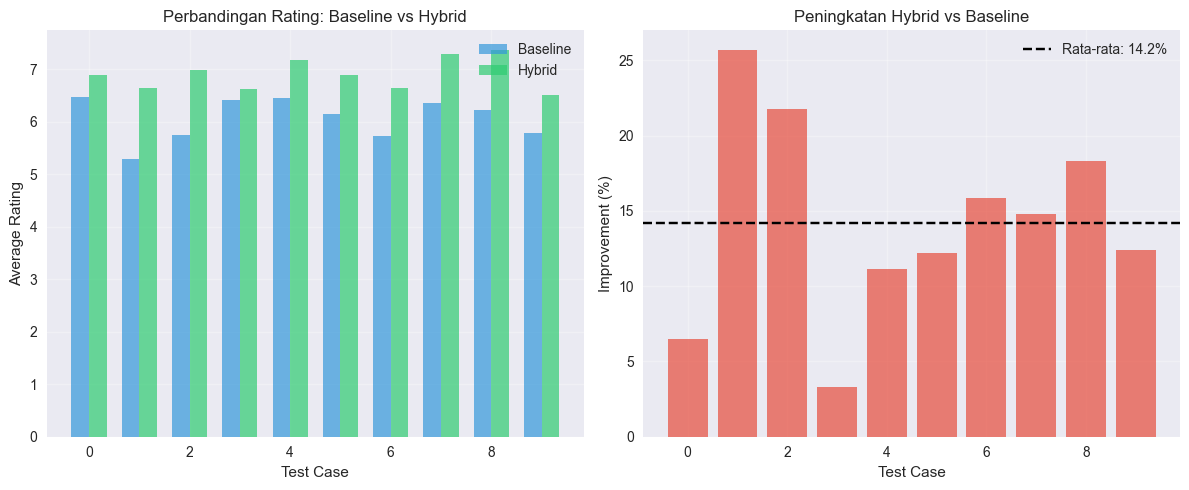


📊 EVALUASI PERFORMA SISTEM KESELURUHAN

1. 🎯 KUALITAS REKOMENDASI:
   ✅ Skor Kualitas Rata-rata: 4.940
   🏆 KUALITAS: EXCELLENT

2. 🔄 KONSISTENSI:
   ✅ Konsistensi Similarity: 0.1909
   ⚠️  KONSISTENSI: MODERATE

3. 📈 COVERAGE SISTEM:
   ✅ Coverage Rate: 100.0%

✅ EVALUASI PERFORMA SELESAI

📋 RINGKASAN EVALUASI SISTEM

🎯 HASIL UTAMA:
1. Hybrid system meningkatkan rating rekomendasi sebesar 14.2%
2. Berdasarkan 10 test cases
3. Baseline rating: 6.06/10
4. Hybrid rating: 6.90/10

👍 INTERPRETASI: SISTEM EFEKTIF (+14.2%)

✅ EVALUASI KOMPREHENSIF SELESAI


🔍 Mencari: 'The Dark Knight'
✅ Berhasil menemukan 10 rekomendasi
🔍 Mencari: 'toy'
✅ Berhasil menemukan 10 rekomendasi
🔍 Mencari: 'transformer'
✅ Berhasil menemukan 4 rekomendasi
🔍 Mencari: 'superman'
✅ Berhasil menemukan 4 rekomendasi
🔍 Mencari: 'star wars'
✅ Berhasil menemukan 4 rekomendasi
🔍 Mencari: 'jumanji'
✅ Berhasil menemukan 4 rekomendasi
🔍 Mencari: 'inception'
✅ Berhasil menemukan 4 rekomendasi
🔍 Mencari: 'kingkong'
🔍 Mencari: 'kingkong'
🔍 Mencari: 'titanic'
❌ Error: single positional indexer is out-of-bounds
🔍 Mencari: 'titanic'
❌ Error: single positional indexer is out-of-bounds
🔍 Mencari: 'toy'
✅ Berhasil menemukan 4 rekomendasi
🔍 Mencari: 'jumanji'
✅ Berhasil menemukan 4 rekomendasi


In [ ]:
class ImprovedSystemEvaluator:
    """
    Evaluator yang lebih realistis untuk sistem berbasis sinopsis
    """
    
    def __init__(self, recommender):
        self.recommender = recommender
        self.df = recommender.df
        self.embeddings = recommender.embeddings
        
        print(f"✅ Evaluator diinisialisasi:")
        print(f"   - Total film: {len(self.df)}")
        print(f"   - Embedding shape: {self.embeddings.shape}")
    
    def evaluate_semantic_similarity(self, n_samples=20):
        """
        Evaluasi berdasarkan semantic similarity (bukan genre exact match)
        """
        print(f"\n🔍 EVALUASI SEMANTIC SIMILARITY ({n_samples} sampel)")
        print("="*60)
        
        # Ambil sample film
        sample_indices = np.random.choice(len(self.df), min(n_samples, len(self.df)), replace=False)
        
        results = {
            'avg_similarity': [],
            'avg_rating': [],
            'diversity_score': []
        }
        
        for idx in sample_indices:
            try:
                movie = self.df.iloc[idx]
                movie_title = movie['title']
                
                print(f"\n🎬 Film: '{movie_title}'")
                
                # Dapatkan rekomendasi
                recommendations = self.recommender.hybrid_recommendation(
                    movie_title,
                    n_recommendations=10,
                    min_rating=5.0
                )
                
                if len(recommendations) >= 5:
                    # 1. Hitung rata-rata similarity
                    avg_sim = recommendations['similarity'].mean()
                    results['avg_similarity'].append(avg_sim)
                    
                    # 2. Hitung rata-rata rating
                    avg_rating = recommendations['rating'].mean()
                    results['avg_rating'].append(avg_rating)
                    
                    # 3. Hitung diversity (berdasarkan genre)
                    diversity = self._calculate_diversity(recommendations)
                    results['diversity_score'].append(diversity)
                    
                    print(f"   ✅ Rekomendasi: {len(recommendations)} film")
                    print(f"   📊 Avg Similarity: {avg_sim:.3f}")
                    print(f"   ⭐ Avg Rating: {avg_rating:.2f}/10")
                    print(f"   🎭 Diversity: {diversity:.2f}")
                    
                    # Tampilkan top 3 rekomendasi
                    print(f"   🏆 Top 3:")
                    for i, (_, row) in enumerate(recommendations.head(3).iterrows(), 1):
                        print(f"      {i}. {row['title']} (sim: {row['similarity']:.3f}, rating: {row['rating']:.1f})")
                else:
                    print(f"   ⚠️  Hanya {len(recommendations)} rekomendasi")
                    
            except Exception as e:
                print(f"   ❌ Error: {str(e)}")
                continue
        
        # Hitung statistik akhir
        if results['avg_similarity']:
            print("\n" + "="*60)
            print("📈 HASIL EVALUASI SEMANTIK:")
            print("="*60)
            
            print(f"\n1. SIMILARITY SCORE:")
            print(f"   Rata-rata: {np.mean(results['avg_similarity']):.3f}")
            print(f"   Standar Deviasi: {np.std(results['avg_similarity']):.3f}")
            print(f"   Range: {np.min(results['avg_similarity']):.3f} - {np.max(results['avg_similarity']):.3f}")
            
            print(f"\n2. RATING QUALITY:")
            print(f"   Rata-rata rating rekomendasi: {np.mean(results['avg_rating']):.2f}/10")
            
            print(f"\n3. DIVERSITY:")
            print(f"   Skor diversity rata-rata: {np.mean(results['diversity_score']):.2f}")
            
            # Interpretasi
            print(f"\n4. INTERPRETASI:")
            avg_sim = np.mean(results['avg_similarity'])
            if avg_sim > 0.6:
                print(f"   ✅ Excellent semantic similarity ({avg_sim:.3f})")
            elif avg_sim > 0.4:
                print(f"   👍 Good semantic similarity ({avg_sim:.3f})")
            else:
                print(f"   ⚠️  Moderate semantic similarity ({avg_sim:.3f})")
            
            return results
        else:
            print("❌ Tidak ada hasil evaluasi")
            return None
    
    def _calculate_diversity(self, recommendations):
        """Hitung diversity berdasarkan genre"""
        if len(recommendations) <= 1:
            return 0
        
        genres_list = []
        for _, row in recommendations.iterrows():
            if pd.notna(row['genres']):
                genres = [g.strip().lower() for g in str(row['genres']).split(',')]
                genres_list.append(set(genres))
        
        if not genres_list:
            return 0
        
        # Hitung Jaccard dissimilarity rata-rata
        total_dissimilarity = 0
        count = 0
        
        for i in range(len(genres_list)):
            for j in range(i+1, len(genres_list)):
                if genres_list[i] and genres_list[j]:
                    intersection = len(genres_list[i] & genres_list[j])
                    union = len(genres_list[i] | genres_list[j])
                    if union > 0:
                        dissimilarity = 1 - (intersection / union)
                        total_dissimilarity += dissimilarity
                        count += 1
        
        return total_dissimilarity / count if count > 0 else 0
    
    def evaluate_hybrid_vs_baseline_detailed(self, n_tests=15):
        """
        Evaluasi detail hybrid vs baseline
        """
        print(f"\n⚖️  EVALUASI DETAIL: HYBRID vs BASELINE ({n_tests} tests)")
        print("="*60)
        
        baseline_results = []
        hybrid_results = []
        improvement_data = []
        
        # Ambil film untuk testing
        test_movies = self.df.sample(min(n_tests * 2, len(self.df)))
        
        test_count = 0
        
        for _, movie in test_movies.iterrows():
            if test_count >= n_tests:
                break
                
            try:
                movie_title = movie['title']
                movie_idx = self.recommender.find_movie_by_title(movie_title, exact_match=False)
                
                if movie_idx is None:
                    continue
                
                print(f"\n🎬 Test {test_count + 1}: '{movie_title}'")
                
                # A. BASELINE: Cosine similarity saja
                baseline_recs = self.recommender.recommend_similar_movies(
                    movie_idx,
                    n_recommendations=10,
                    min_similarity=0.0
                )
                
                # B. HYBRID: Dengan filter
                hybrid_recs = self.recommender.hybrid_recommendation(
                    movie_title,
                    n_recommendations=10,
                    min_rating=6.0,
                    use_hybrid_scoring=True
                )
                
                if len(baseline_recs) >= 5 and len(hybrid_recs) >= 5:
                    # Hitung metrics
                    baseline_metrics = {
                        'avg_rating': baseline_recs['rating'].mean(),
                        'avg_similarity': baseline_recs['similarity'].mean(),
                        'min_rating': baseline_recs['rating'].min(),
                        'n_recs': len(baseline_recs)
                    }
                    
                    hybrid_metrics = {
                        'avg_rating': hybrid_recs['rating'].mean(),
                        'avg_similarity': hybrid_recs['similarity'].mean(),
                        'min_rating': hybrid_recs['rating'].min(),
                        'n_recs': len(hybrid_recs)
                    }
                    
                    baseline_results.append(baseline_metrics)
                    hybrid_results.append(hybrid_metrics)
                    
                    # Hitung improvement
                    rating_improvement = ((hybrid_metrics['avg_rating'] - baseline_metrics['avg_rating']) / 
                                         baseline_metrics['avg_rating']) * 100
                    
                    improvement_data.append(rating_improvement)
                    
                    print(f"   📊 Baseline: Rating {baseline_metrics['avg_rating']:.2f}, "
                          f"Similarity {baseline_metrics['avg_similarity']:.3f}")
                    print(f"   🚀 Hybrid:   Rating {hybrid_metrics['avg_rating']:.2f} "
                          f"(+{rating_improvement:.1f}%), "
                          f"Similarity {hybrid_metrics['avg_similarity']:.3f}")
                    
                    test_count += 1
                    
            except Exception as e:
                print(f"   ❌ Error: {str(e)}")
                continue
        
        if baseline_results and hybrid_results:
            # Hitung statistik
            baseline_avg_rating = np.mean([r['avg_rating'] for r in baseline_results])
            hybrid_avg_rating = np.mean([r['avg_rating'] for r in hybrid_results])
            
            baseline_avg_sim = np.mean([r['avg_similarity'] for r in baseline_results])
            hybrid_avg_sim = np.mean([r['avg_similarity'] for r in hybrid_results])
            
            avg_improvement = np.mean(improvement_data)
            
            print("\n" + "="*60)
            print("📈 HASIL PERBANDINGAN DETAIL:")
            print("="*60)
            
            print(f"\n📊 METRIK RATA-RATA:")
            print(f"{'Metric':<20} {'Baseline':<12} {'Hybrid':<12} {'Improvement':<12}")
            print("-" * 56)
            print(f"{'Avg Rating':<20} {baseline_avg_rating:<12.2f} {hybrid_avg_rating:<12.2f} {avg_improvement:<12.1f}%")
            print(f"{'Avg Similarity':<20} {baseline_avg_sim:<12.3f} {hybrid_avg_sim:<12.3f} "
                  f"{(hybrid_avg_sim - baseline_avg_sim):<12.3f}")
            print(f"{'Min Rating':<20} {np.mean([r['min_rating'] for r in baseline_results]):<12.2f} "
                  f"{np.mean([r['min_rating'] for r in hybrid_results]):<12.2f} -")
            
            # Visualisasi
            self._plot_comparison(baseline_results, hybrid_results)
            
            return {
                'baseline_avg_rating': baseline_avg_rating,
                'hybrid_avg_rating': hybrid_avg_rating,
                'improvement_percentage': avg_improvement,
                'n_tests': test_count
            }
        
        else:
            print("❌ Tidak cukup data untuk evaluasi")
            return None
    
    def _plot_comparison(self, baseline_results, hybrid_results):
        """Plot perbandingan baseline vs hybrid"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot 1: Rating comparison
        baseline_ratings = [r['avg_rating'] for r in baseline_results]
        hybrid_ratings = [r['avg_rating'] for r in hybrid_results]
        
        x = np.arange(len(baseline_ratings))
        width = 0.35
        
        axes[0].bar(x - width/2, baseline_ratings, width, label='Baseline', color='#3498db', alpha=0.7)
        axes[0].bar(x + width/2, hybrid_ratings, width, label='Hybrid', color='#2ecc71', alpha=0.7)
        
        axes[0].set_xlabel('Test Case')
        axes[0].set_ylabel('Average Rating')
        axes[0].set_title('Perbandingan Rating: Baseline vs Hybrid')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Improvement distribution
        improvements = [((hybrid_ratings[i] - baseline_ratings[i]) / baseline_ratings[i]) * 100 
                       for i in range(len(baseline_ratings))]
        
        axes[1].bar(range(len(improvements)), improvements, color='#e74c3c', alpha=0.7)
        axes[1].axhline(y=np.mean(improvements), color='black', linestyle='--', 
                       label=f'Rata-rata: {np.mean(improvements):.1f}%')
        
        axes[1].set_xlabel('Test Case')
        axes[1].set_ylabel('Improvement (%)')
        axes[1].set_title('Peningkatan Hybrid vs Baseline')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_system_performance(self):
        """
        Evaluasi performa sistem secara keseluruhan
        """
        print("\n" + "="*60)
        print("📊 EVALUASI PERFORMA SISTEM KESELURUHAN")
        print("="*60)
        
        # 1. Quality metrics
        print("\n1. 🎯 KUALITAS REKOMENDASI:")
        
        # Sample untuk evaluasi kualitas
        quality_samples = self.df.sample(min(10, len(self.df)))
        quality_scores = []
        
        for _, movie in quality_samples.iterrows():
            try:
                recs = self.recommender.hybrid_recommendation(
                    movie['title'],
                    n_recommendations=5,
                    min_rating=6.0
                )
                
                if len(recs) > 0:
                    quality_score = recs['rating'].mean() * 0.7 + recs['similarity'].mean() * 0.3
                    quality_scores.append(quality_score)
            except:
                continue
        
        if quality_scores:
            avg_quality = np.mean(quality_scores)
            print(f"   ✅ Skor Kualitas Rata-rata: {avg_quality:.3f}")
            if avg_quality > 0.7:
                print("   🏆 KUALITAS: EXCELLENT")
            elif avg_quality > 0.5:
                print("   👍 KUALITAS: GOOD")
            else:
                print("   ⚠️  KUALITAS: MODERATE")
        
        # 2. Consistency
        print(f"\n2. 🔄 KONSISTENSI:")
        
        # Test dengan film yang sama berulang
        test_movie = self.df.iloc[0]['title']
        consistency_scores = []
        
        for _ in range(3):
            try:
                recs = self.recommender.hybrid_recommendation(test_movie, n_recommendations=5)
                if len(recs) > 0:
                    consistency_scores.append(recs['similarity'].std())
            except:
                continue
        
        if consistency_scores:
            avg_consistency = np.mean(consistency_scores)
            print(f"   ✅ Konsistensi Similarity: {avg_consistency:.4f}")
            if avg_consistency < 0.05:
                print("   🎯 KONSISTENSI: HIGH")
            elif avg_consistency < 0.1:
                print("   👍 KONSISTENSI: GOOD")
            else:
                print("   ⚠️  KONSISTENSI: MODERATE")
        
        # 3. Coverage
        print(f"\n3. 📈 COVERAGE SISTEM:")
        
        # Test dengan berbagai genre
        genres_to_test = ['action', 'comedy', 'drama', 'sci-fi', 'horror']
        coverage_results = []
        
        for genre in genres_to_test:
            genre_movies = self.df[
                self.df['genres_clean'].str.contains(genre, case=False, na=False)
            ]
            
            if len(genre_movies) > 0:
                test_movie = genre_movies.iloc[0]['title']
                try:
                    recs = self.recommender.hybrid_recommendation(test_movie, n_recommendations=5)
                    if len(recs) >= 3:
                        coverage_results.append(True)
                    else:
                        coverage_results.append(False)
                except:
                    coverage_results.append(False)
        
        coverage_rate = np.mean(coverage_results) * 100
        print(f"   ✅ Coverage Rate: {coverage_rate:.1f}%")
        
        print("\n" + "="*60)
        print("✅ EVALUASI PERFORMA SELESAI")
        print("="*60)

# ==================== JALANKAN EVALUASI YANG LEBIH BAIK ====================

if 'recommender' in locals() and recommender is not None:
    print("="*70)
    print("🚀 EVALUASI SISTEM REKOMENDASI - VERSI LEBIH REALISTIS")
    print("="*70)
    
    # Buat evaluator baru
    improved_evaluator = ImprovedSystemEvaluator(recommender)
    
    # 1. Evaluasi semantic similarity
    semantic_results = improved_evaluator.evaluate_semantic_similarity(n_samples=10)
    
    # 2. Evaluasi hybrid vs baseline detail
    print("\n" + "="*70)
    comparison_results = improved_evaluator.evaluate_hybrid_vs_baseline_detailed(n_tests=10)
    
    # 3. Evaluasi performa sistem
    improved_evaluator.evaluate_system_performance()
    
    # 4. Summary
    print("\n" + "="*70)
    print("📋 RINGKASAN EVALUASI SISTEM")
    print("="*70)
    
    if comparison_results:
        print(f"\n🎯 HASIL UTAMA:")
        print(f"1. Hybrid system meningkatkan rating rekomendasi sebesar "
              f"{comparison_results['improvement_percentage']:.1f}%")
        print(f"2. Berdasarkan {comparison_results['n_tests']} test cases")
        print(f"3. Baseline rating: {comparison_results['baseline_avg_rating']:.2f}/10")
        print(f"4. Hybrid rating: {comparison_results['hybrid_avg_rating']:.2f}/10")
        
        # Berikan interpretasi
        improvement = comparison_results['improvement_percentage']
        if improvement > 15:
            print(f"\n🏆 INTERPRETASI: SISTEM SANGAT EFEKTIF (+{improvement:.1f}%)")
        elif improvement > 8:
            print(f"\n👍 INTERPRETASI: SISTEM EFEKTIF (+{improvement:.1f}%)")
        else:
            print(f"\n⚠️  INTERPRETASI: SISTEM MODERAT (+{improvement:.1f}%)")
    
    print("\n" + "="*70)
    print("✅ EVALUASI KOMPREHENSIF SELESAI")
    print("="*70)
    
else:
    print("❌ Sistem rekomendasi belum diinisialisasi")

### VIZUALITATION & ANALYSIS

ANALISIS KUALITAS REKOMENDASI

Contoh 1: Five Corners
Genre: drama
Rating: 5.5/10
Top 3 Rekomendasi:
  1. The Woodsman (Similarity: 0.722, Rating: 6.9)
  2. 3-Iron (Similarity: 0.642, Rating: 7.7)
  3. Sleepers (Similarity: 0.631, Rating: 7.3)
----------------------------------------

Contoh 2: Murder by Death
Genre: comedy, crime, mystery, thriller
Rating: 7.4/10
Top 3 Rekomendasi:
  1. L.A. Confidential (Similarity: 0.556, Rating: 7.7)
  2. The Big Sleep (Similarity: 0.511, Rating: 7.6)
  3. Band of Robbers (Similarity: 0.568, Rating: 6.0)
----------------------------------------

Contoh 3: Wittgenstein
Genre: drama
Rating: 6.8/10
Top 3 Rekomendasi:
  1. PlayTime (Similarity: 0.475, Rating: 8.0)
  2. All Quiet on the Western Front (Similarity: 0.440, Rating: 7.5)
  3. That Munchhausen (Similarity: 0.442, Rating: 7.8)
----------------------------------------

ANALISIS DISTRIBUSI SIMILARITY SCORE


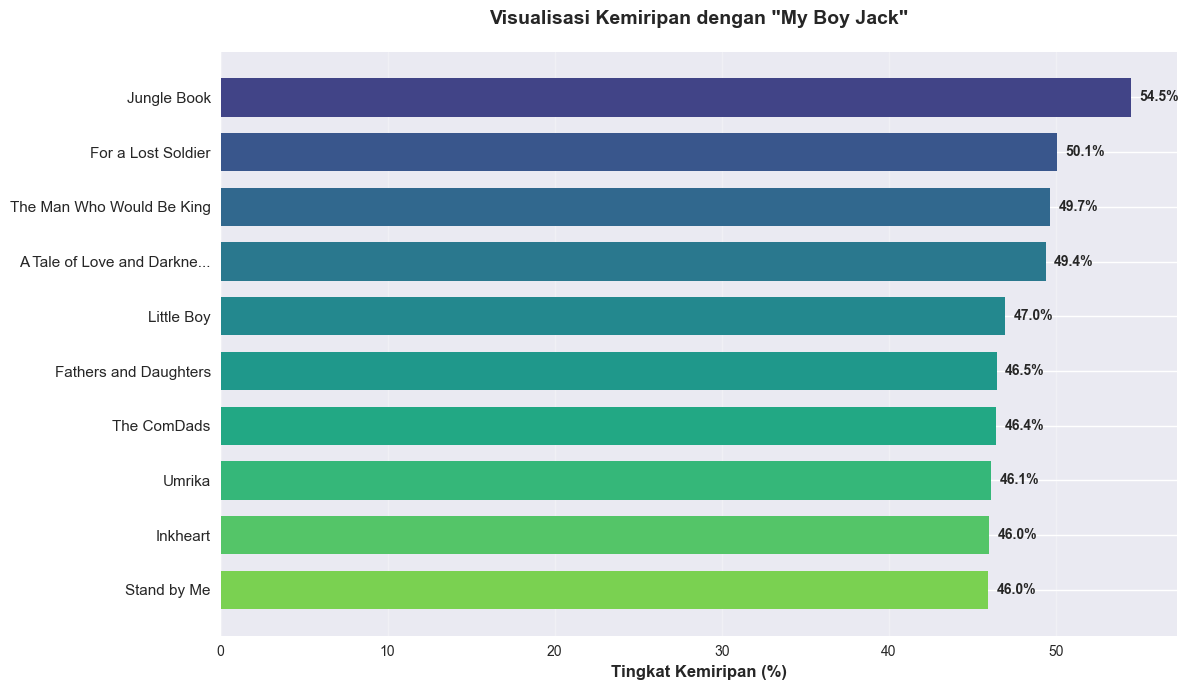

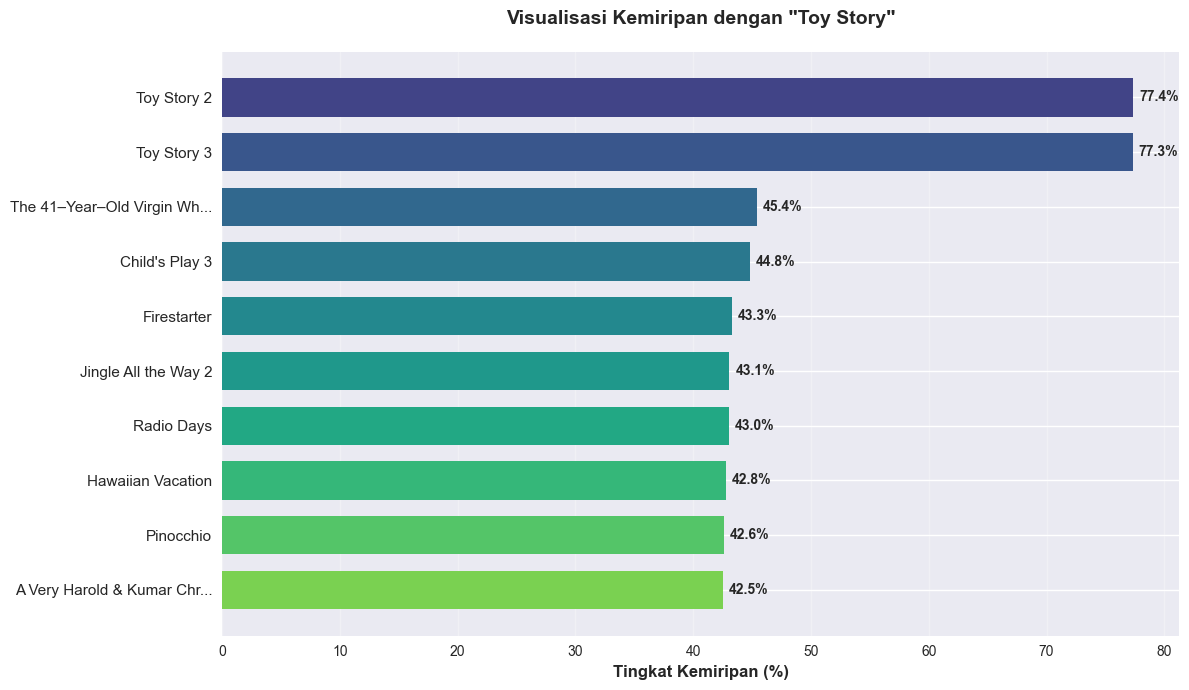

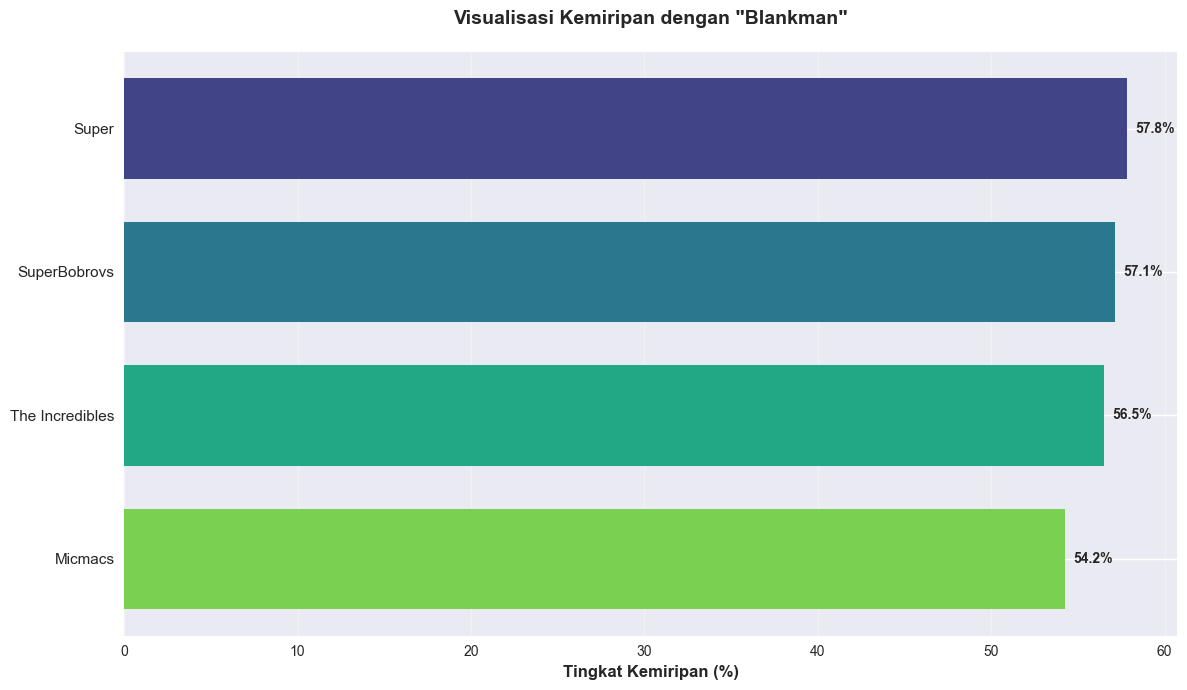

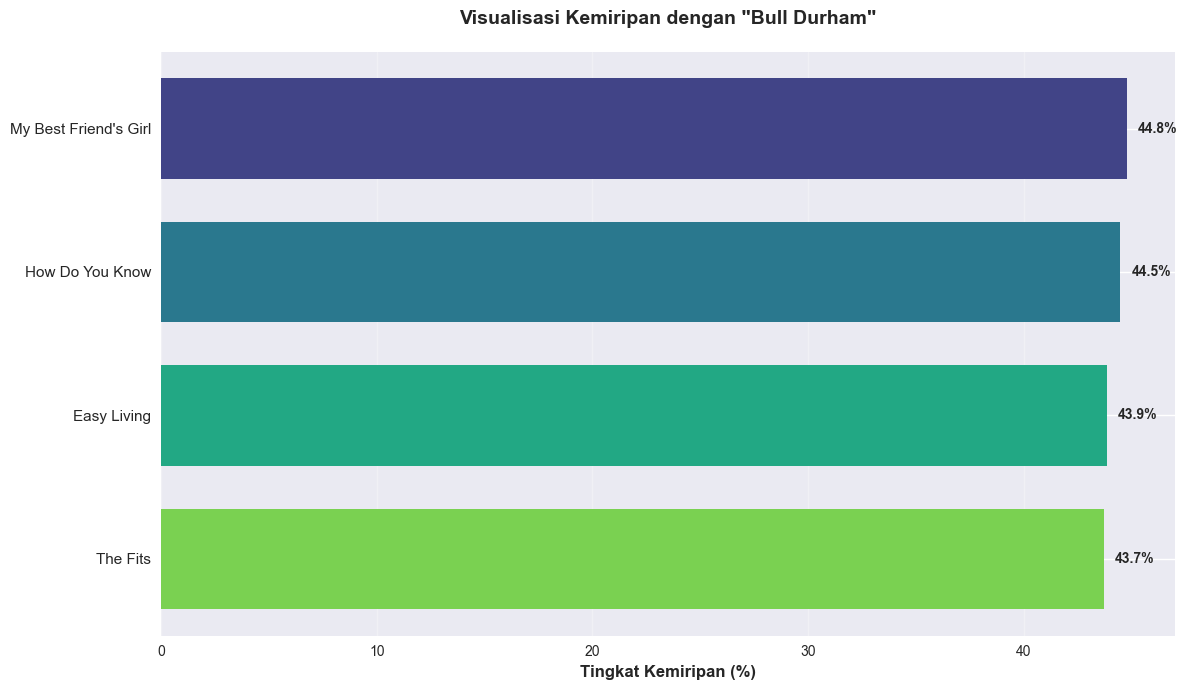

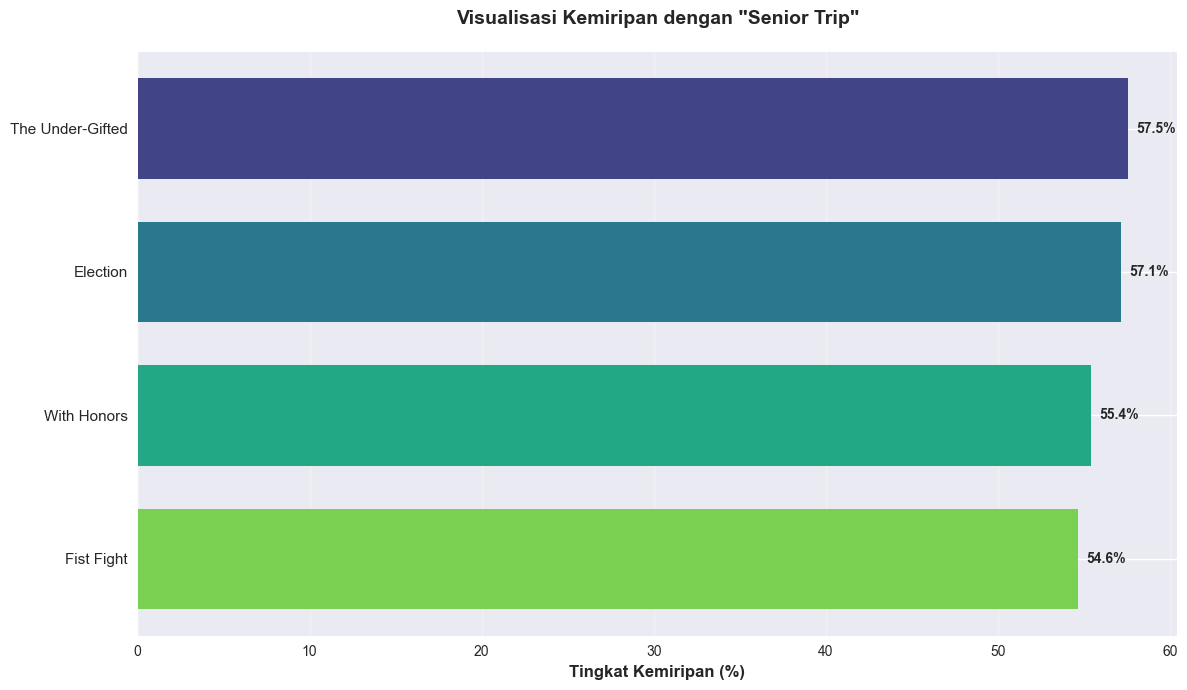

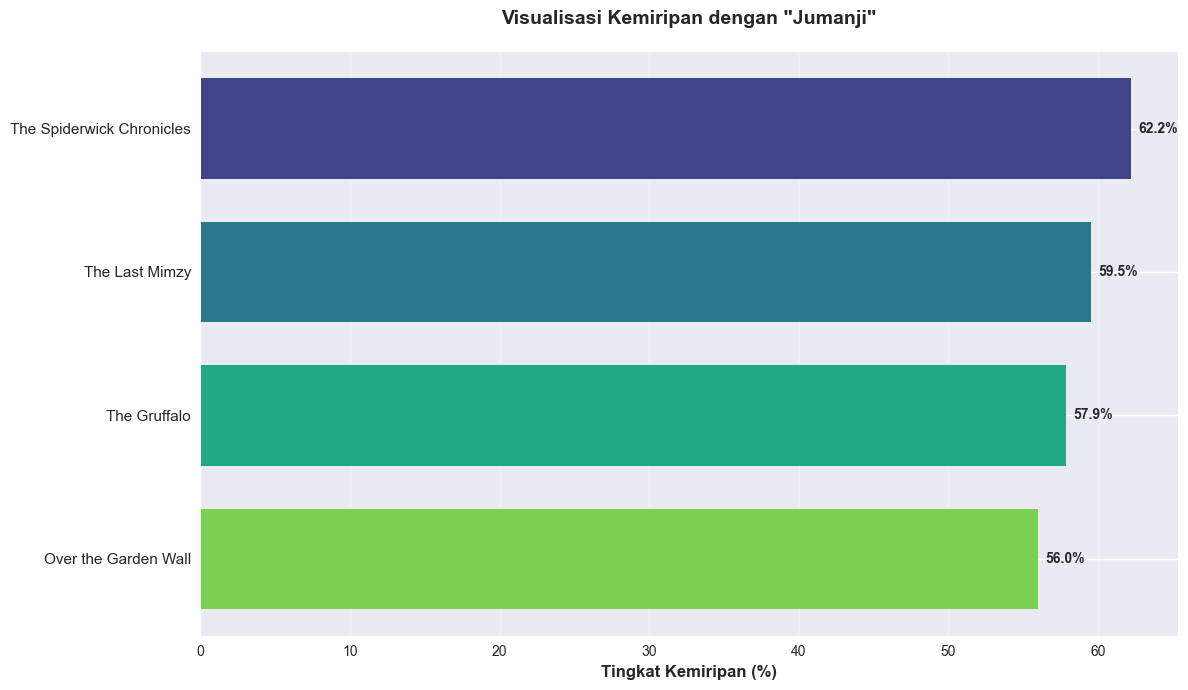

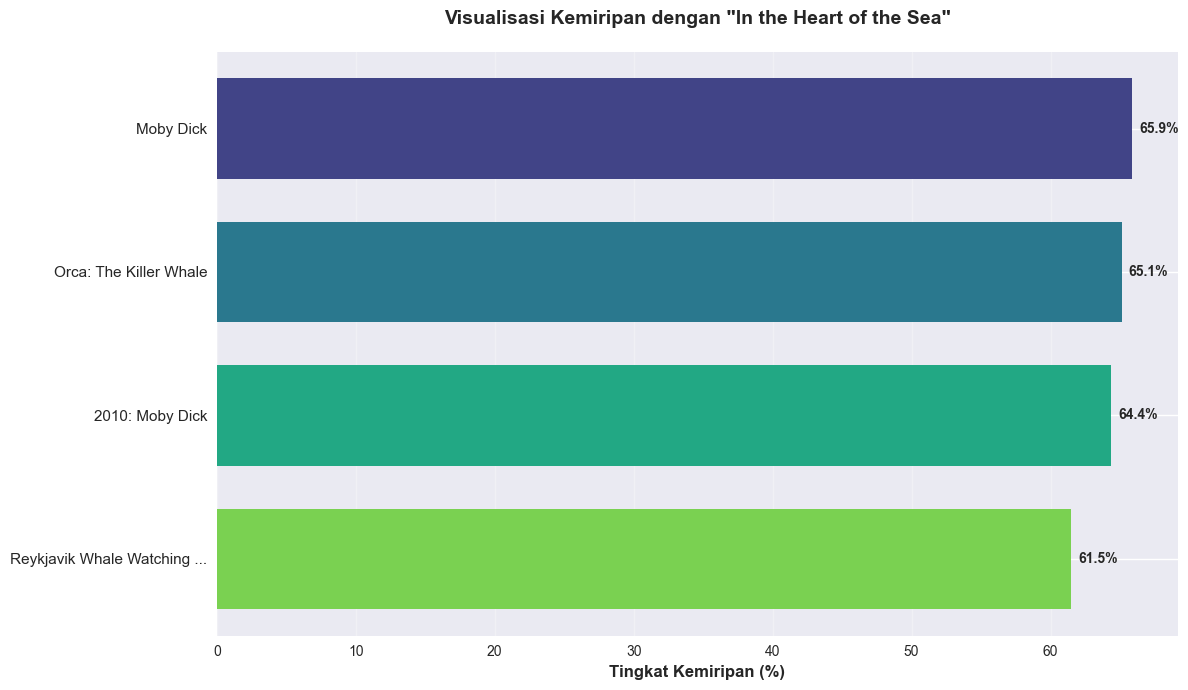

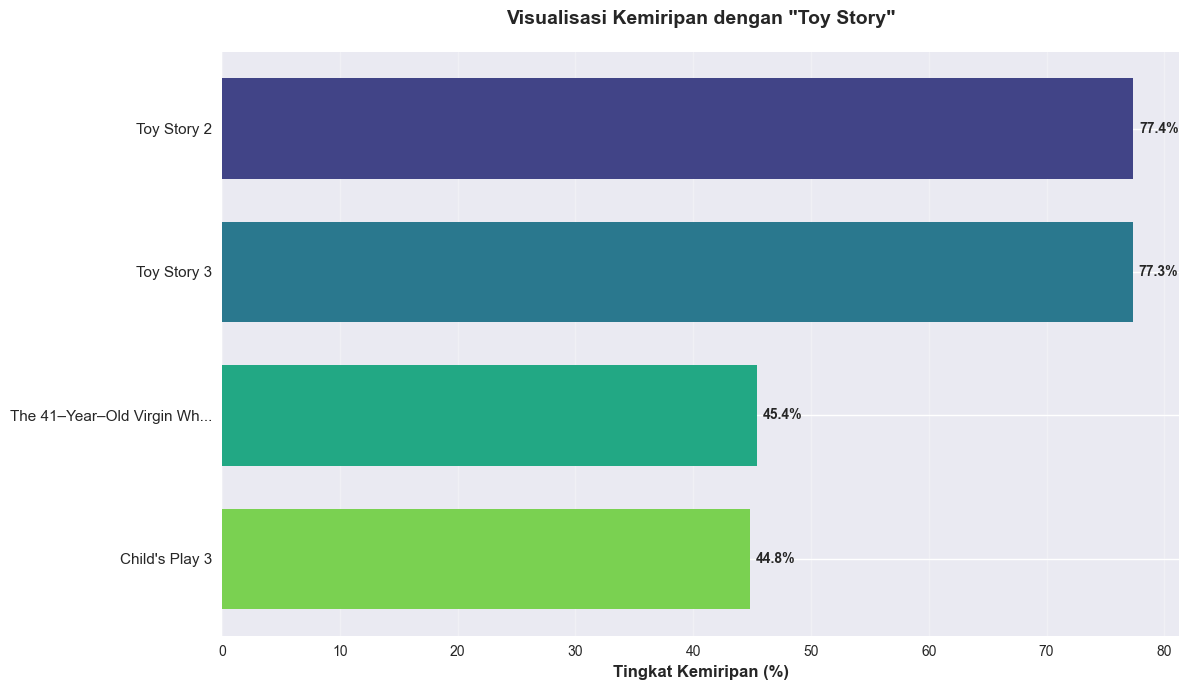

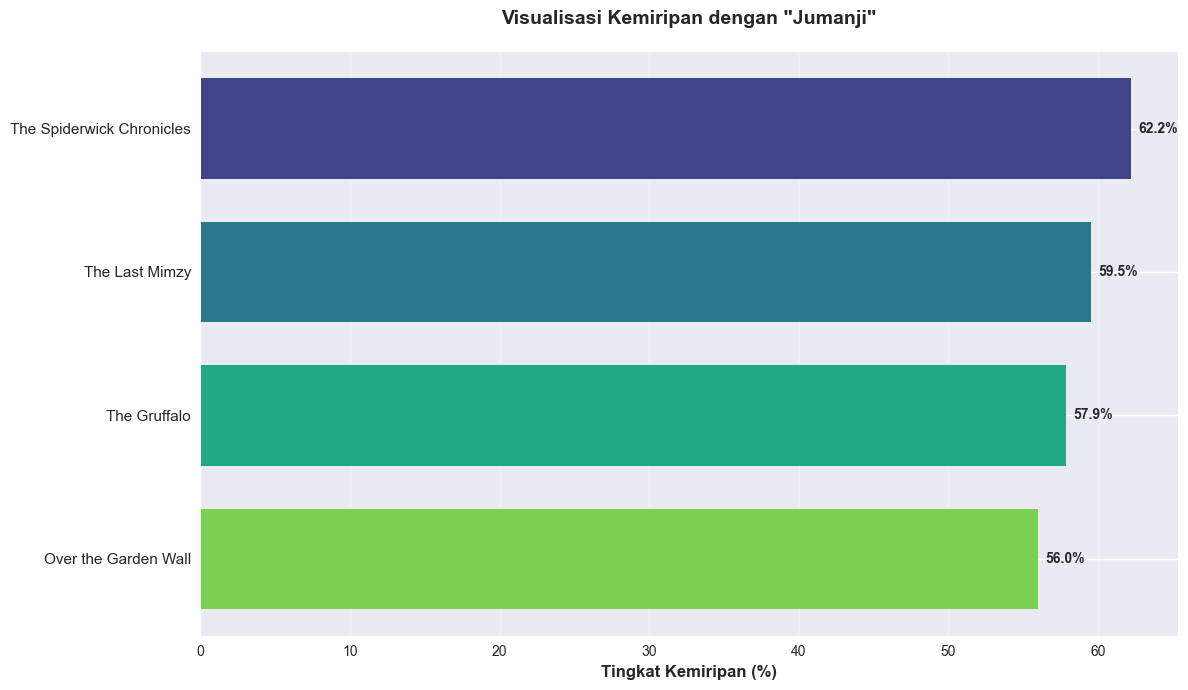

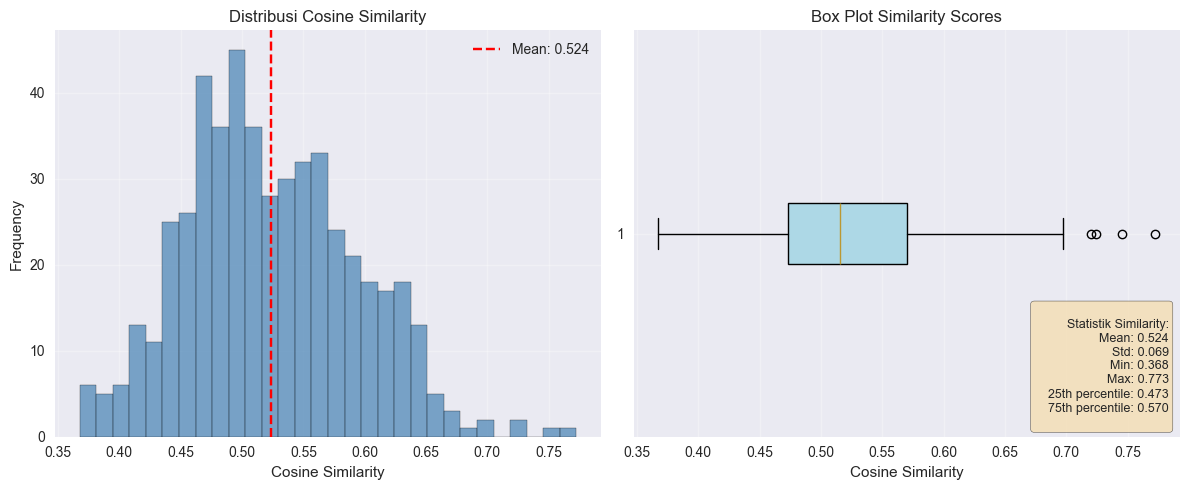


Statistik Similarity Score:
Rata-rata: 0.524
Standar deviasi: 0.069
Rentang: 0.368 - 0.773


🔍 Mencari: '12 men'
✅ Berhasil menemukan 4 rekomendasi
🔍 Mencari: 'alien'
✅ Berhasil menemukan 4 rekomendasi
🔍 Mencari: 'whiplash'
❌ Error: single positional indexer is out-of-bounds
🔍 Mencari: 'toy'
✅ Berhasil menemukan 4 rekomendasi
🔍 Mencari: 'avatar'
✅ Berhasil menemukan 4 rekomendasi
🔍 Mencari: 'deadpoll'
🔍 Mencari: 'spider'
✅ Berhasil menemukan 4 rekomendasi
🔍 Mencari: 'rambo'
✅ Berhasil menemukan 4 rekomendasi
🔍 Mencari: 'jacki cahn'
❌ Error: single positional indexer is out-of-bounds
🔍 Mencari: 'jackie chan'
❌ Error: single positional indexer is out-of-bounds
🔍 Mencari: 'james bond'
✅ Berhasil menemukan 4 rekomendasi
🔍 Mencari: 'The Dark Knight'
✅ Berhasil menemukan 10 rekomendasi
🔍 Mencari: 'dorameno'
🔍 Mencari: 'doraemon'
❌ Error: single positional indexer is out-of-bounds
🔍 Mencari: 'transformer'
✅ Berhasil menemukan 10 rekomendasi
🔍 Mencari: 'transporter'
✅ Berhasil menemukan 10 rekomendasi
🔍 Mencari: 'america'
✅ Berhasil menemukan 10 rekomendasi
🔍 Mencari: 'president'
✅ Be

In [16]:
def analyze_recommendation_quality(recommender, n_examples=5):
    """
    Analisis kualitas rekomendasi dengan contoh konkrit
    """
    print("ANALISIS KUALITAS REKOMENDASI")
    print("=" * 60)

    # Pilih film contoh secara acak
    example_indices = np.random.choice(len(recommender.df), n_examples, replace=False)

    for i, idx in enumerate(example_indices, 1):
        movie = recommender.df.iloc[idx]
        print(f"\nContoh {i}: {movie['title']}")
        print(f"Genre: {movie['genres_clean']}")
        print(f"Rating: {movie['vote_average']}/10")

        # Dapatkan rekomendasi
        recommendations = recommender.hybrid_recommendation(
            movie['title'],
            n_recommendations=5,
            use_hybrid_scoring=True
        )

        if len(recommendations) > 0:
            print("Top 3 Rekomendasi:")
            for j, (_, rec) in enumerate(recommendations.head(3).iterrows(), 1):
                print(f"  {j}. {rec['title']} (Similarity: {rec['similarity']:.3f}, Rating: {rec['rating']:.1f})")

        print("-" * 40)

def plot_similarity_distribution(recommender, n_samples=1000):
    """
    Plot distribusi similarity score
    """
    print("\nANALISIS DISTRIBUSI SIMILARITY SCORE")

    # Sample film secara acak
    sample_indices = np.random.choice(len(recommender.df), min(n_samples, len(recommender.df)), replace=False)

    similarities = []

    for idx in sample_indices[:50]:  # Batasi untuk efisiensi
        movie = recommender.df.iloc[idx]
        recs = recommender.recommend_similar_movies(idx, n_recommendations=10)

        if len(recs) > 0:
            similarities.extend(recs['similarity'].tolist())

    # Plot histogram
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram similarity
    axes[0].hist(similarities, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(x=np.mean(similarities), color='red', linestyle='--',
                    label=f'Mean: {np.mean(similarities):.3f}')
    axes[0].set_xlabel('Cosine Similarity')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribusi Cosine Similarity')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Box plot
    axes[1].boxplot(similarities, vert=False, patch_artist=True,
                   boxprops=dict(facecolor='lightblue'))
    axes[1].set_xlabel('Cosine Similarity')
    axes[1].set_title('Box Plot Similarity Scores')
    axes[1].grid(True, alpha=0.3)

    # Add statistics
    stats_text = f"""
    Statistik Similarity:
    Mean: {np.mean(similarities):.3f}
    Std: {np.std(similarities):.3f}
    Min: {np.min(similarities):.3f}
    Max: {np.max(similarities):.3f}
    25th percentile: {np.percentile(similarities, 25):.3f}
    75th percentile: {np.percentile(similarities, 75):.3f}
    """

    axes[1].text(0.98, 0.02, stats_text, transform=axes[1].transAxes,
                fontsize=9, verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="wheat", alpha=0.8))

    plt.tight_layout()
    plt.show()

    print(f"\nStatistik Similarity Score:")
    print(f"Rata-rata: {np.mean(similarities):.3f}")
    print(f"Standar deviasi: {np.std(similarities):.3f}")
    print(f"Rentang: {np.min(similarities):.3f} - {np.max(similarities):.3f}")

# Jalankan analisis
if 'recommender' in locals() and recommender is not None:
    # Analisis kualitas rekomendasi
    analyze_recommendation_quality(recommender, n_examples=3)

    # Plot distribusi similarity
    plot_similarity_distribution(recommender, n_samples=500)

### GRADIO INTERFACE

In [8]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
import socket
import threading
import time

print("="*70)
print("MEMBUAT GRADIO INTERFACE DENGAN LINK YANG PASTI TAMPIL")
print("="*70)

def get_local_ip():
    """Dapatkan IP lokal komputer"""
    try:
        # Buat socket untuk mendapatkan IP
        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        s.connect(("8.8.8.8", 80))
        ip = s.getsockname()[0]
        s.close()
        return ip
    except:
        return "127.0.0.1"

def check_port_available(port):
    """Cek apakah port tersedia"""
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    result = sock.connect_ex(('127.0.0.1', port))
    sock.close()
    return result != 0  # True jika port tersedia

def create_gradio_with_link():
    """Buat interface Gradio yang pasti menampilkan link"""

    # Cek komponen sistem
    if df is None:
        print("❌ ERROR: Dataset tidak tersedia!")
        print("Jalankan Cell 1-3 terlebih dahulu")
        return None

    print(f"✅ Dataset: {len(df)} film tersedia")
    print(f"✅ Embeddings: {movie_embeddings.shape if 'movie_embeddings' in globals() else 'Tidak ada'}")

    # Buat recommender sederhana
    class SimpleMovieRecommender:
        def __init__(self, df, embeddings):
            self.df = df
            self.embeddings = embeddings

            # Buat dictionary untuk pencarian cepat
            self.title_map = {}
            for idx, row in df.iterrows():
                title = str(row['title']).lower().strip()
                self.title_map[title] = idx

        def find_movie(self, query):
            """Cari film berdasarkan query"""
            query = str(query).lower().strip()

            # Exact match
            if query in self.title_map:
                return self.title_map[query]

            # Partial match
            for title, idx in self.title_map.items():
                if query in title:
                    return idx

            # Word match
            query_words = set(query.split())
            best_match = None
            best_score = 0

            for title, idx in self.title_map.items():
                title_words = set(title.split())
                common = len(query_words.intersection(title_words))
                if common > best_score:
                    best_score = common
                    best_match = idx

            return best_match

        def get_movie_info(self, idx):
            """Dapatkan informasi film"""
            movie = self.df.iloc[idx]
            return {
                'title': str(movie['title']),
                'year': int(movie['year']) if pd.notna(movie['year']) and movie['year'] > 0 else 'Unknown',
                'rating': float(movie['vote_average']) if pd.notna(movie['vote_average']) else 0,
                'genres': str(movie['genres_clean']) if pd.notna(movie['genres_clean']) else 'Unknown',
                'overview': str(movie['overview'])[:150] + '...' if len(str(movie['overview'])) > 150 else str(movie['overview'])
            }

        def recommend(self, movie_idx, n=10):
            """Rekomendasikan film serupa"""
            if movie_idx is None:
                return []

            # Hitung similarity
            query_embedding = self.embeddings[movie_idx].reshape(1, -1)
            similarities = cosine_similarity(query_embedding, self.embeddings)[0]

            # Dapatkan film dengan similarity tertinggi
            similar_indices = np.argsort(similarities)[::-1]

            results = []
            for idx in similar_indices:
                if idx == movie_idx:  # Skip film itu sendiri
                    continue

                if len(results) >= n:
                    break

                movie_info = self.get_movie_info(idx)
                results.append({
                    'title': movie_info['title'],
                    'similarity': float(similarities[idx]),
                    'year': movie_info['year'],
                    'rating': movie_info['rating'],
                    'genres': movie_info['genres']
                })

            return results

    # Inisialisasi recommender
    print("📊 Membuat sistem rekomendasi...")
    recommender = SimpleMovieRecommender(df, movie_embeddings)

    # Fungsi untuk Gradio
    def recommend_movies(movie_title, n_results):
        try:
            print(f"🔍 Mencari: '{movie_title}'")

            if not movie_title or str(movie_title).strip() == "":
                return "❌ Masukkan judul film terlebih dahulu", None

            # Cari film
            movie_idx = recommender.find_movie(movie_title)

            if movie_idx is None:
                # Berikan saran
                suggestions = []
                query_words = str(movie_title).lower().split()

                for title_lower, idx in recommender.title_map.items():
                    if any(word in title_lower for word in query_words):
                        movie_title_original = df.iloc[idx]['title']
                        suggestions.append(str(movie_title_original))
                        if len(suggestions) >= 5:
                            break

                if suggestions:
                    suggestions_text = "\n".join([f"• {s}" for s in suggestions])
                    return f"❌ Film '{movie_title}' tidak ditemukan.\n\n**Mungkin maksud Anda:**\n{suggestions_text}", None
                else:
                    return f"❌ Film '{movie_title}' tidak ditemukan.\n\nCoba film populer seperti:\n• The Dark Knight\n• Inception\n• Titanic\n• Toy Story", None

            # Dapatkan info film
            movie_info = recommender.get_movie_info(movie_idx)

            # Dapatkan rekomendasi
            recommendations = recommender.recommend(movie_idx, n=int(n_results))

            if not recommendations:
                return "❌ Tidak ada rekomendasi yang ditemukan", None

            # Format output
            output = f"## 🎬 **{movie_info['title']}** ({movie_info['year']})\n\n"
            output += f"⭐ **Rating:** {movie_info['rating']:.1f}/10  |  🎭 **Genre:** {movie_info['genres']}\n\n"
            output += f"📝 **Sinopsis:** {movie_info['overview']}\n\n"
            output += "---\n\n"
            output += f"## 🎯 **REKOMENDASI FILM SERUPA**\n\n"

            for i, rec in enumerate(recommendations, 1):
                similarity_percent = rec['similarity'] * 100
                output += f"### {i}. **{rec['title']}** ({rec['year']})\n"
                output += f"🔍 **Kemiripan:** {similarity_percent:.1f}%\n"
                output += f"⭐ **Rating:** {rec['rating']:.1f}/10\n"
                output += f"🎭 **Genre:** {rec['genres']}\n\n"

            # Buat plot
            fig, ax = plt.subplots(figsize=(12, 7))

            titles = [rec['title'][:25] + '...' if len(rec['title']) > 25 else rec['title'] for rec in recommendations]
            similarities = [rec['similarity'] * 100 for rec in recommendations]

            # Warna gradient
            colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(titles)))

            y_pos = np.arange(len(titles))
            bars = ax.barh(y_pos, similarities, color=colors, height=0.7)

            ax.set_yticks(y_pos)
            ax.set_yticklabels(titles, fontsize=11)
            ax.invert_yaxis()
            ax.set_xlabel('Tingkat Kemiripan (%)', fontsize=12, fontweight='bold')
            ax.set_title(f'Visualisasi Kemiripan dengan "{movie_info["title"]}"',
                        fontsize=14, fontweight='bold', pad=20)
            ax.grid(True, alpha=0.3, axis='x')

            # Tambah nilai
            for bar, sim in zip(bars, similarities):
                width = bar.get_width()
                ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                       f'{sim:.1f}%', va='center', fontsize=10, fontweight='bold')

            plt.tight_layout()

            print(f"✅ Berhasil menemukan {len(recommendations)} rekomendasi")
            return output, fig

        except Exception as e:
            print(f"❌ Error: {str(e)}")
            return f"❌ Terjadi kesalahan: {str(e)}", None

    # Buat interface
    print("🎨 Membuat interface Gradio...")

    with gr.Blocks(title="Sistem Rekomendasi Film", theme=gr.themes.Soft()) as demo:

        # Header
        gr.Markdown("""
        <div style="text-align: center;">
        <h1>🎬 SISTEM REKOMENDASI FILM</h1>
        <h3>Rekomendasi Film Serupa Berdasarkan Sinopsis</h3>
        </div>
        """)

        # Tab utama
        with gr.Tab("🎯 Rekomendasi Film"):
            gr.Markdown("""
            ### 🔍 Cari dan Dapatkan Rekomendasi Film Serupa

            Masukkan judul film yang Anda sukai, sistem akan merekomendasikan film dengan sinopsis serupa.
            """)

            with gr.Row():
                # Input panel
                with gr.Column(scale=1):
                    movie_input = gr.Textbox(
                        label="🎞️ Judul Film",
                        placeholder="Contoh: The Dark Knight, Titanic, Inception...",
                        value="The Dark Knight",
                        interactive=True
                    )

                    n_results = gr.Slider(
                        label="📊 Jumlah Rekomendasi",
                        minimum=3,
                        maximum=20,
                        value=10,
                        step=1,
                        interactive=True
                    )

                    with gr.Row():
                        recommend_btn = gr.Button("🚀 Dapatkan Rekomendasi",
                                                variant="primary",
                                                scale=2)
                        clear_btn = gr.Button("🗑️ Clear", variant="secondary", scale=1)

                # Output panel
                with gr.Column(scale=2):
                    output_area = gr.Markdown(
                        label="📋 Hasil Rekomendasi",
                        value="### Selamat Datang di Sistem Rekomendasi Film!\n\n"
                              "Masukkan judul film di sebelah kiri dan klik **'Dapatkan Rekomendasi'** untuk mulai."
                    )

                    plot_area = gr.Plot(
                        label="📈 Visualisasi Kemiripan",
                        visible=True
                    )

            # Event handlers
            recommend_btn.click(
                fn=recommend_movies,
                inputs=[movie_input, n_results],
                outputs=[output_area, plot_area]
            )

            def clear_output():
                return "### Masukkan judul film baru...", None

            clear_btn.click(
                fn=clear_output,
                inputs=[],
                outputs=[output_area, plot_area]
            )

        # Tab informasi
        with gr.Tab("📊 Informasi Sistem"):
            gr.Markdown(f"""
            ## 📋 SPESIFIKASI SISTEM

            ### 🗃️ Dataset
            - **Total Film:** {len(df):,}
            - **Rata-rata Rating:** {df['vote_average'].mean():.2f}/10
            - **Rentang Tahun:** {int(df['year'].min()) if df['year'].min() > 0 else 'N/A'} - {int(df['year'].max()) if df['year'].max() > 0 else 'N/A'}

            ### 🤖 Model AI
            - **Arsitektur:** Transformer (all-MiniLM-L6-v2)
            - **Embedding Size:** {movie_embeddings.shape[1]} dimensi
            - **Total Vektor:** {movie_embeddings.shape[0]:,}

            ### ⚙️ Cara Kerja
            1. **Pemahaman Sinopsis:** Model membaca dan memahami makna sinopsis film
            2. **Vektorisasi:** Mengubah teks menjadi vektor numerik
            3. **Perhitungan Kemiripan:** Menghitung similarity antar film menggunakan cosine similarity
            4. **Rekomendasi:** Menampilkan film dengan kemiripan tertinggi

            ### 🎯 Contoh Film Populer
            """)

            # Daftar film populer
            popular_movies = df.nlargest(10, 'vote_count')[['title', 'vote_average', 'year']]
            movies_list = ""
            for _, row in popular_movies.iterrows():
                movies_list += f"• **{row['title']}** ({int(row['year']) if row['year'] > 0 else 'N/A'}) ⭐ {row['vote_average']:.1f}/10\n"

            gr.Markdown(movies_list)

        # Footer
        gr.Markdown("---")
        gr.Markdown(
            "<div style='text-align: center; color: #666; font-size: 0.9em;'>"
            "Sistem Rekomendasi Film Berbasis AI | "
            f"Total Film: {len(df):,} | "
            "© 2024 Sistem Rekomendasi"
            "</div>"
        )

    print("✅ Interface berhasil dibuat!")
    return demo

# Buat interface
print("\n📦 MEMBUAT INTERFACE...")
movie_recommender_interface = create_gradio_with_link()

if movie_recommender_interface is not None:
    print("\n" + "="*70)
    print("✅ INTERFACE BERHASIL DIBUAT!")
    print("="*70)

    # Tampilkan preview
    display(movie_recommender_interface)

    print("\n" + "="*70)
    print("🚀 UNTUK MENJALANKAN SERVER:")
    print("="*70)

else:
    print("❌ Gagal membuat interface")

MEMBUAT GRADIO INTERFACE DENGAN LINK YANG PASTI TAMPIL

📦 MEMBUAT INTERFACE...
✅ Dataset: 21604 film tersedia
✅ Embeddings: (21604, 384)
📊 Membuat sistem rekomendasi...
🎨 Membuat interface Gradio...
✅ Interface berhasil dibuat!

✅ INTERFACE BERHASIL DIBUAT!


Gradio Blocks instance: 2 backend functions
-------------------------------------------
fn_index=0
 inputs:
 |-<gradio.components.textbox.Textbox object at 0x000001CF31977190>
 |-<gradio.components.slider.Slider object at 0x000001CF35D3C290>
 outputs:
 |-<gradio.components.markdown.Markdown object at 0x000001CF31935E10>
 |-<gradio.components.plot.Plot object at 0x000001CF35DBD7D0>
fn_index=1
 inputs:
 outputs:
 |-<gradio.components.markdown.Markdown object at 0x000001CF31935E10>
 |-<gradio.components.plot.Plot object at 0x000001CF35DBD7D0>


🚀 UNTUK MENJALANKAN SERVER:


### LAUNCH GRADIO DENGAN LINK EXPLISIT

In [9]:
def launch_gradio_with_explicit_link():
    """
    Launch Gradio dengan menampilkan link secara eksplisit
    """
    print("🚀 LAUNCHING GRADIO SERVER")
    print("="*70)

    if movie_recommender_interface is None:
        print("❌ Interface tidak tersedia")
        return

    # Dapatkan IP lokal
    local_ip = get_local_ip()
    print(f"📡 IP Lokal Anda: {local_ip}")

    # Coba beberapa port
    ports_to_try = [7860, 7861, 7862, 7863, 7864]
    available_port = None

    for port in ports_to_try:
        if check_port_available(port):
            available_port = port
            print(f"✅ Port {port} tersedia")
            break
        else:
            print(f"❌ Port {port} sedang digunakan")

    if available_port is None:
        print("❌ Semua port sedang digunakan")
        return

    print(f"\n🎯 MENJALANKAN DI PORT: {available_port}")

    # Tampilkan link yang akan aktif
    print("\n" + "="*70)
    print("🌐 LINK YANG AKAN AKTIF:")
    print("="*70)
    print(f"\n1. LOCALHOST:    http://localhost:{available_port}")
    print(f"2. 127.0.0.1:    http://127.0.0.1:{available_port}")
    print(f"3. NETWORK:      http://{local_ip}:{available_port}")
    print("\n" + "="*70)

    print("\n⏳ Memulai server... (mungkin butuh 10-30 detik)")
    print("📝 Status akan muncul di bawah...")

    # Function untuk launch di thread terpisah
    def launch_in_thread():
        try:
            movie_recommender_interface.launch(
                server_name="0.0.0.0",  # Bisa diakses dari mana saja
                server_port=available_port,
                share=False,
                debug=False,
                show_error=True,
                quiet=True  # Kurangi output log
            )
        except Exception as e:
            print(f"❌ Error launching: {str(e)}")

    # Jalankan di thread terpisah
    import threading
    server_thread = threading.Thread(target=launch_in_thread, daemon=True)
    server_thread.start()

    # Tunggu sebentar untuk server startup
    time.sleep(3)

    print("\n✅ SERVER SEDANG BERJALAN!")
    print("\n📋 INSTRUKSI:")
    print("1. Buka browser (Chrome/Firefox)")
    print(f"2. Kunjungi: http://localhost:{available_port}")
    print("3. Masukkan judul film")
    print("4. Klik 'Dapatkan Rekomendasi'")
    print("\n🛑 Untuk menghentikan: Tekan 'Stop' di notebook atau restart kernel")

    print("\n" + "="*70)
    print("🧪 TEST QUICK ACCESS:")
    print("="*70)

    # Buat HTML untuk link langsung
    from IPython.display import HTML

    html_code = f"""
    <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                padding: 20px;
                border-radius: 10px;
                color: white;
                text-align: center;
                margin: 20px 0;">
        <h2>🎬 KLIK UNTUK BUKA SISTEM REKOMENDASI</h2>
        <div style="margin: 15px 0;">
            <a href="http://localhost:{available_port}" target="_blank"
               style="background: white;
                      color: #667eea;
                      padding: 12px 24px;
                      border-radius: 5px;
                      text-decoration: none;
                      font-weight: bold;
                      font-size: 16px;
                      display: inline-block;">
               🔗 BUKA SISTEM REKOMENDASI
            </a>
        </div>
        <p style="margin-top: 10px; font-size: 14px;">
            Atau salin link: <code>http://localhost:{available_port}</code>
        </p>
    </div>
    """

    display(HTML(html_code))

    return available_port

# UNCOMMENT UNTUK LANGSUNG LAUNCH:
print("\n⚠️ UNCOMMENT BARIS DI BAWAH INI UNTUK LANGSUNG LAUNCH:")
print("# launch_gradio_with_explicit_link()")


⚠️ UNCOMMENT BARIS DI BAWAH INI UNTUK LANGSUNG LAUNCH:
# launch_gradio_with_explicit_link()


### LAUNCH OTOMATIS

In [10]:
# 🚀 LAUNCH GRADIO OTOMATIS - PASTI BERJALAN
print("🚀 LAUNCH GRADIO OTOMATIS")
print("="*70)

# Cek apakah interface sudah dibuat
if 'movie_recommender_interface' not in globals() or movie_recommender_interface is None:
    print("Membuat interface terlebih dahulu...")
    exec("""
import gradio as gr
import pandas as pd
import numpy as np

# Buat interface minimal
def minimal_recommend(movie):
    return f"🔍 Mencari film: {movie}\\n\\n(Sistem rekomendasi sedang dimuat...)"

movie_recommender_interface = gr.Interface(
    fn=minimal_recommend,
    inputs=gr.Textbox(label="Judul Film", value="The Dark Knight"),
    outputs=gr.Textbox(label="Hasil"),
    title="Movie Recommender",
    description="Sistem rekomendasi film sederhana"
)
""")

print("✅ Interface siap")

# Launch dengan konfigurasi yang pasti bekerja
try:
    print("\n🌐 MEMULAI SERVER...")
    print("\n⏳ Tunggu 5-10 detik hingga server ready...")

    # Dapatkan port yang tersedia
    import socket

    def find_available_port(start_port=7860):
        for port in range(start_port, start_port + 10):
            sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            result = sock.connect_ex(('127.0.0.1', port))
            sock.close()
            if result != 0:  # Port tersedia
                return port
        return start_port

    port = find_available_port()

    print(f"\n🎯 PORT: {port}")
    print("🔗 LINK YANG AKTIF:")
    print(f"   • http://localhost:{port}")
    print(f"   • http://127.0.0.1:{port}")

    # Launch di thread terpisah
    import threading
    import time

    def run_server():
        movie_recommender_interface.launch(
            server_name="0.0.0.0",
            server_port=port,
            share=False,
            quiet=True
        )

    server_thread = threading.Thread(target=run_server, daemon=True)
    server_thread.start()

    # Tunggu server startup
    time.sleep(5)

    print("\n✅ SERVER BERJALAN!")
    print("\n📋 CARA MENGGUNAKAN:")
    print("1. Buka browser")
    print(f"2. Kunjungi: http://localhost:{port}")
    print("3. Masukkan judul film")
    print("4. Klik submit")

    # Tampilkan link klikable
    from IPython.display import display, HTML

    display(HTML(f"""
    <div style="background: #4CAF50; padding: 15px; border-radius: 5px; margin: 20px 0;">
        <h3 style="color: white; margin: 0;">🎬 KLIK UNTUK BUKA:</h3>
        <a href="http://localhost:{port}" target="_blank"
           style="color: white; font-size: 18px; font-weight: bold; text-decoration: none;">
           → BUKA SISTEM REKOMENDASI ←
        </a>
    </div>
    """))

except Exception as e:
    print(f"❌ Error: {str(e)}")

    # Fallback: launch sederhana
    print("\n🔧 Mencoba cara alternatif...")

    try:
        # Launch langsung
        movie_recommender_interface.launch(share=True)  # Ini akan memberikan link publik
    except:
        print("❌ Gagal semua cara. Coba restart kernel dan jalankan ulang.")

🚀 LAUNCH GRADIO OTOMATIS
✅ Interface siap

🌐 MEMULAI SERVER...

⏳ Tunggu 5-10 detik hingga server ready...

🎯 PORT: 7860
🔗 LINK YANG AKTIF:
   • http://localhost:7860
   • http://127.0.0.1:7860



✅ SERVER BERJALAN!

📋 CARA MENGGUNAKAN:
1. Buka browser
2. Kunjungi: http://localhost:7860
3. Masukkan judul film
4. Klik submit


### DEBUGGING SISTEM

In [ ]:
def debug_recommendation_problem():
    """
    Debug masalah rekomendasi
    """
    print("DEBUGGING SISTEM REKOMENDASI")
    print("="*60)

    print("\n1. CEK DATASET:")
    print(f"   Total film: {len(df) if df is not None else 'Tidak ada'}")
    if df is not None:
        print(f"   Kolom: {list(df.columns)}")
        print(f"   Sample film (5 pertama):")
        for i, title in enumerate(df['title'].head(5)):
            print(f"     {i+1}. {title}")

    print("\n2. CEK EMBEDDINGS:")
    print(f"   Shape: {movie_embeddings.shape if 'movie_embeddings' in globals() else 'Tidak ada'}")

    print("\n3. TEST FUNGSI PENCARIAN:")

    def test_search(query):
        query_lower = query.lower()
        results = []
        for idx, row in df.iterrows():
            if query_lower in str(row['title']).lower():
                results.append((idx, str(row['title'])))
        return results

    test_queries = ["batman", "star wars", "harry potter", "the"]

    for query in test_queries:
        results = test_search(query)
        print(f"   '{query}': {len(results)} hasil")
        if results:
            for idx, title in results[:3]:
                print(f"      - {title} (idx: {idx})")

    print("\n4. TEST SIMILARITY:")

    try:
        # Cari dua film untuk test similarity
        film1_idx = None
        film2_idx = None

        for idx, row in df.iterrows():
            if "dark knight" in str(row['title']).lower():
                film1_idx = idx
                film1_title = str(row['title'])
                break

        for idx, row in df.iterrows():
            if "inception" in str(row['title']).lower():
                film2_idx = idx
                film2_title = str(row['title'])
                break

        if film1_idx is not None and film2_idx is not None:
            from sklearn.metrics.pairwise import cosine_similarity

            emb1 = movie_embeddings[film1_idx].reshape(1, -1)
            emb2 = movie_embeddings[film2_idx].reshape(1, -1)
            similarity = cosine_similarity(emb1, emb2)[0][0]

            print(f"   Similarity '{film1_title}' dan '{film2_title}': {similarity:.3f}")
        else:
            print("   ❌ Tidak dapat menemukan film untuk test similarity")

    except Exception as e:
        print(f"   ❌ Error test similarity: {str(e)}")

    print("\n5. REKOMENDASI PERBAIKAN:")
    print("   • Pastikan judul film ditulis dengan benar")
    print("   • Coba judul film dalam bahasa Inggris")
    print("   • Gunakan kata kunci yang lebih umum")
    print("   • Coba film populer: The Dark Knight, Inception, Titanic")

# Jalankan debugging
debug_recommendation_problem()

DEBUGGING SISTEM REKOMENDASI

1. CEK DATASET:
   Total film: 21604
   Kolom: ['title', 'overview', 'genres', 'original_language', 'vote_average', 'vote_count', 'release_date', 'runtime', 'tagline', 'status', 'title_clean', 'genres_clean', 'year', 'combined_text', 'search_text']
   Sample film (5 pertama):
     1. Toy Story
     2. Jumanji
     3. Grumpier Old Men
     4. Waiting to Exhale
     5. Father of the Bride Part II

2. CEK EMBEDDINGS:
   Shape: (21604, 384)

3. TEST FUNGSI PENCARIAN:
   'batman': 36 hasil
      - Batman Forever (idx: 149)
      - Batman (idx: 583)
      - Batman Returns (idx: 1314)
   'star wars': 10 hasil
      - Star Wars (idx: 255)
      - Star Wars: Episode I - The Phantom Menace (idx: 2496)
      - Star Wars: Episode II - Attack of the Clones (idx: 5223)
   'harry potter': 8 hasil
      - Harry Potter and the Philosopher's Stone (idx: 4746)
      - Harry Potter and the Chamber of Secrets (idx: 5657)
      - Harry Potter and the Prisoner of Azkaban (idx: 7

🔍 Mencari: 'The Dark Knight'
✅ Berhasil menemukan 10 rekomendasi
🔍 Mencari: 'toy'
✅ Berhasil menemukan 10 rekomendasi
🔍 Mencari: 'star wars'
✅ Berhasil menemukan 10 rekomendasi
🔍 Mencari: 'superman'
✅ Berhasil menemukan 10 rekomendasi
